# **Import Modules**

- `!pip install split-folders -q`  
  Menginstal library `split-folders` secara quiet mode atau tidak menampilkan prosesnya. Modul ini digunakan untuk membagi dataset ke folder train/val/test.Khusus modul ini perlu diinstall pada Colab karena belum tersedia.

- **Library umum:**
  - `os`, `pathlib.Path`: Mengatur jalur direktori dan file.
  - `numpy`, `pandas`: Pemrosesan data numerik dan tabular.
  - `matplotlib.pyplot`, `seaborn`: Visualisasi data.

- **Pemrosesan gambar:**
  - `PIL.Image`: Untuk memuat dan memanipulasi citra.

- **TensorFlow dan Keras:**
  - `tensorflow`, `keras`: Framework utama deep learning.
  - `layers`, `callbacks`, `optimizers`, `models`, dll: Komponen utama untuk membangun dan melatih model.
  - `keras.applications`: Model pretrained seperti `EfficientNetB0`, `ResNet50V2`, dan `MobileNetV3Large`.
  - `backend (K)`: Akses backend TensorFlow untuk operasi tingkat rendah.
  - `regularizers.l2`: Digunakan untuk regularisasi (menghindari overfitting).

- **Evaluasi model:**
  - `sklearn.metrics`: Untuk menghitung metrik evaluasi seperti confusion matrix dan classification report.

In [29]:
!pip install split-folders -q

In [30]:
import kagglehub
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import splitfolders

from PIL import Image
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, callbacks, optimizers
from tensorflow.keras.applications import EfficientNetB0, ResNet50V2, MobileNetV3Large
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.regularizers import l2
from pathlib import Path

# **Download Data**
- `kagglehub.dataset_download("asdasdasasdas/garbage-classification")`:  
  Mengunduh dataset *Garbage Classification* dari Kaggle menggunakan `kagglehub`. Dataset ini berisi gambar berbagai jenis sampah.

- `main_data_path = "/kaggle/input/garbage-classification/Garbage classification/Garbage classification"`:  
  Menentukan jalur direktori utama tempat dataset tersimpan setelah diunduh. Jalur ini menunjuk ke folder yang berisi subfolder masing-masing kelas sampah, seperti:
  - `Paper/`
  - `Plastic/`
  - `Metal/`
  - `Glass/`
  - `Cardboard/`
  - `Trash/`


In [31]:
path = kagglehub.dataset_download("asdasdasasdas/garbage-classification")

main_data_path = "/kaggle/input/garbage-classification/Garbage classification/Garbage classification"

# **Split Dataset**

### Fungsi `load_images_from_folder`
- **Tujuan:** Memuat semua gambar dari sub-folder dalam satu folder utama, dan mengembalikan daftar array gambar serta labelnya.
- **Langkah:**
  1. Loop melalui setiap sub-folder di `folder` (nama sub-folder = label).
  2. Buka setiap file gambar dengan `PIL.Image`, konversi ke RGB, lalu ubah menjadi `numpy` array.
  3. Simpan array gambar ke `images` dan nama sub-folder ke `labels`.
  4. Tangani error loading dengan menampilkan pesan, agar proses tidak terhenti jika ada file korup.


In [32]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)
        if os.path.isdir(path):
            for img_filename in os.listdir(path):
                img_path = os.path.join(path, img_filename)
                try:
                    img = Image.open(img_path)
                    img = img.convert('RGB')
                    images.append(np.array(img))
                    labels.append(filename)
                except Exception as e:
                    print(f"Error loading image: {img_path}, {e}")
    return images, labels

### Fungsi `plot_label_distribution`
- **Tujuan:** Menampilkan bar chart distribusi jumlah gambar per label.
- **Langkah:**
  1. Buat `pd.Series` dari `labels` dan hitung `value_counts()`.
  2. Gunakan `seaborn.barplot` untuk mem-plot nama label di sumbu-X dan jumlah di sumbu-Y.
  3. Tambahkan judul yang mencantumkan total gambar, serta label sumbu.

In [33]:
def plot_label_distribution(labels, title):
    label_counts = pd.Series(labels).value_counts()
    total_counts = label_counts.sum()
    plt.figure(figsize=(10, 5))
    sns.barplot(x=label_counts.index, y=label_counts.values)
    plt.title(f"{title} - Total {total_counts} Images")
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.show()

In [34]:
splitfolders.ratio(main_data_path, output="/content/dataset", seed=1337, ratio=(.8, .1, .1))

Copying files: 2527 files [00:07, 322.17 files/s]


In [35]:
TRAIN_PATH = '/content/dataset/train'
VAL_PATH = '/content/dataset/val'
TEST_PATH = '/content/dataset/test'

In [36]:
img_train, labels_train = load_images_from_folder(TRAIN_PATH)
img_val, labels_val = load_images_from_folder(VAL_PATH)
img_test, labels_test = load_images_from_folder(TEST_PATH)

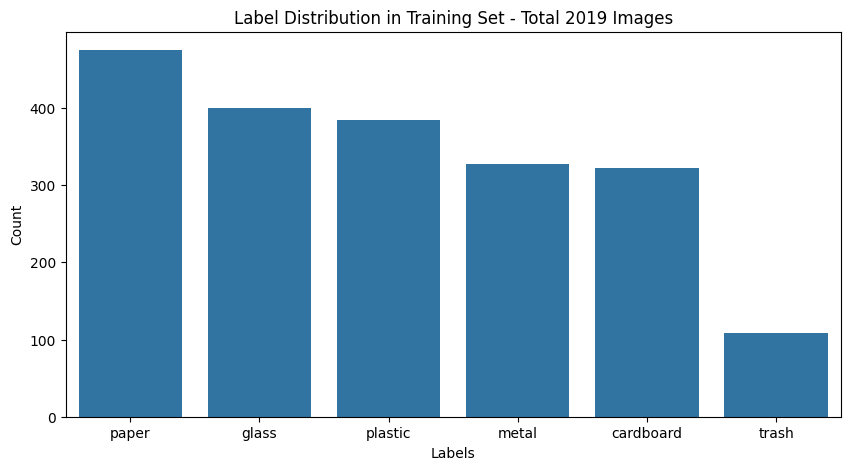

In [37]:
plot_label_distribution(labels_train, 'Label Distribution in Training Set')

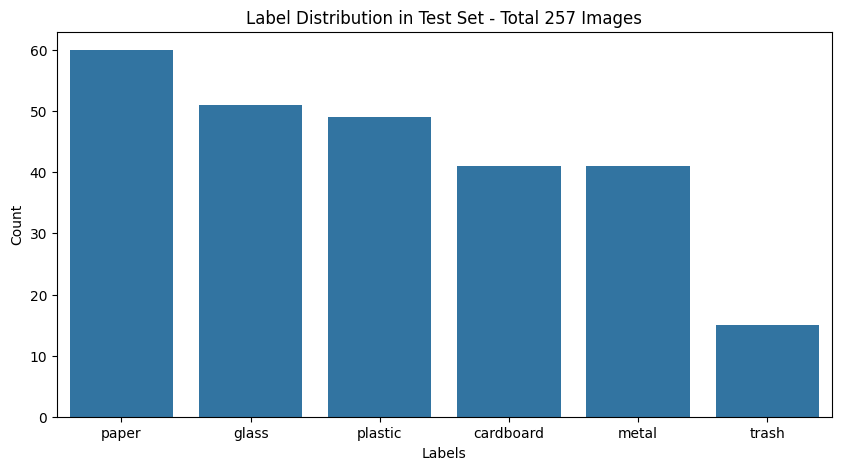

In [38]:
plot_label_distribution(labels_test, 'Label Distribution in Test Set')

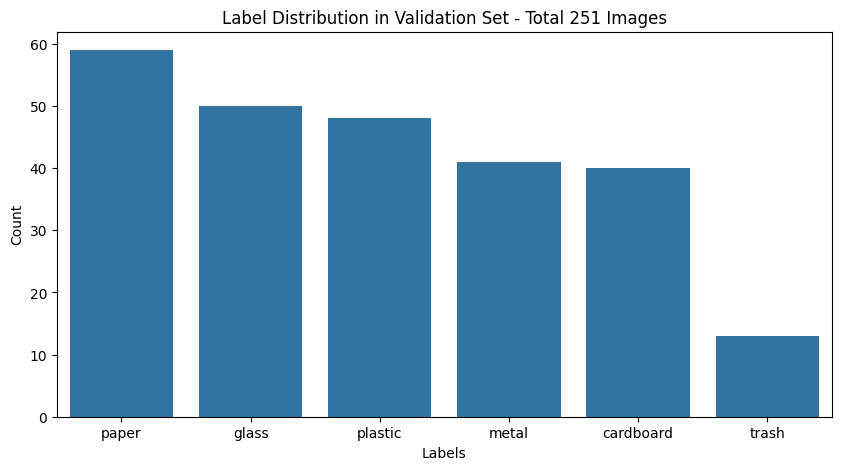

In [39]:
plot_label_distribution(labels_val, 'Label Distribution in Validation Set')

# **Create Dataset**

Fungsi ini digunakan untuk memuat dataset gambar dari direktori yang sudah dipisahkan sebelumnya (`train/`, `val/`, `test/`) dan mengembalikannya dalam bentuk `tf.data.Dataset` yang efisien untuk pelatihan model.

### 🔧 Parameter:
- **`base_dir`**: Path direktori utama yang berisi folder `train`, `val`, dan `test`.
- **`image_size`**: Ukuran gambar yang diubah ukurannya (default: 224×224).
- **`batch_size`**: Ukuran batch untuk proses training (default: 32).

### 🔄 Langkah-langkah:
1. Membuat dataset dari masing-masing folder dengan `image_dataset_from_directory()`.
   - Label dikonversi ke format one-hot (`label_mode='categorical'`).
   - `shuffle=False` hanya digunakan untuk test agar evaluasi akurat.

2. Menyimpan nama kelas dari folder `train`:
   ```python
   class_indices = train_ds.class_names
   
3. Optimasi pipeline data:

   * **`cache()`**: Menyimpan data di memori (RAM) untuk efisiensi.
   * **`shuffle(1000)`**: Mengacak data train agar tidak bias urutan.
   * **`prefetch(AUTOTUNE)`**: Memuat data berikutnya di background saat batch sebelumnya sedang dilatih (efisiensi CPU+GPU).

In [40]:
def create_datasets(base_dir, image_size=(224,224),batch_size=32):
    """Create training, validation, and test datasets from pre-split folders"""
    train_dir = os.path.join(base_dir, "train")
    val_dir = os.path.join(base_dir, "val")
    test_dir = os.path.join(base_dir, "test")

    train_ds = keras.utils.image_dataset_from_directory(
        train_dir,
        image_size=image_size,
        batch_size=batch_size,
        label_mode='categorical'
    )

    val_ds = keras.utils.image_dataset_from_directory(
        val_dir,
        image_size=image_size,
        batch_size=batch_size,
        label_mode='categorical'
    )

    test_ds = keras.utils.image_dataset_from_directory(
        test_dir,
        image_size=image_size,
        batch_size=batch_size,
        label_mode='categorical',
        shuffle=False
    )

    class_indices = train_ds.class_names

    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

    return train_ds, val_ds, test_ds, class_indices

In [41]:
train_ds , val_ds, test_ds, class_indices = create_datasets('/content/dataset')

Found 2019 files belonging to 6 classes.
Found 251 files belonging to 6 classes.
Found 257 files belonging to 6 classes.


# **Data Augmentation & Preprocessing**

### 🧪 `create_data_augmentation()`
Fungsi ini mengembalikan layer augmentasi data menggunakan `keras.Sequential`. Augmentasi membantu model lebih robust terhadap variasi data dengan transformasi berikut:
- `RandomFlip("horizontal")`: Membalik gambar secara horizontal secara acak.
- `RandomRotation(0.2)`: Memutar gambar hingga ±20% dari sudut rotasi penuh (setara ±72°).
- `RandomZoom(0.2)`: Memperbesar gambar hingga ±20% secara acak.
- `RandomContrast(0.1)`: Mengubah kontras gambar hingga ±10%.

### 🧼 `create_preprocessing(cat)`
Fungsi ini memberikan preprocessing yang sesuai berdasarkan model yang digunakan:

- **Jika model = `ResNetV2`**:
  - Menggunakan `layers.Rescaling(scale=1./127.5, offset=-1)` untuk menormalkan piksel dari [0, 255] ke [-1, 1].

- **Untuk model lain (seperti EfficientNet, MobileNet, dll)**:
  - `Rescaling(1./255)`: Menormalkan ke [0, 1].
  - `Normalization(...)`: Menyesuaikan nilai pixel dengan mean dan variance yang umum digunakan pada model pretrained ImageNet.

In [42]:
def create_data_augmentation():
    return keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.2),
            layers.RandomZoom(0.2),
            layers.RandomContrast(0.1),
        ], name="data_augmentation")

In [43]:
def create_preprocessing(cat):
    if cat == "ResnetV2":

      return keras.Sequential([
            layers.Rescaling(scale=1./127.5, offset=-1)
        ], name="preprocessing")

    else:

      return keras.Sequential([
            layers.Rescaling(1./255),
            layers.Normalization(mean=[0.485, 0.456, 0.406],
                                 variance=[0.229**2, 0.224**2, 0.225**2])
        ])

# **Modeling**

### 🔧 `callbacks_build(model_name)`
Fungsi ini membuat daftar *callback* yang digunakan selama proses pelatihan model deep learning untuk memantau dan meningkatkan performa.

#### 📌 Callback yang digunakan:
1. **ModelCheckpoint**
   - Menyimpan bobot terbaik berdasarkan *val_accuracy* tertinggi.
   - Path penyimpanan: `/content/models/{model_name}.weights.h5`
   - Hanya menyimpan *weights*, bukan seluruh model.
   - `save_best_only=True` memastikan hanya bobot terbaik yang disimpan.

2. **EarlyStopping**
   - Menghentikan pelatihan lebih awal jika *val_accuracy* tidak meningkat selama 10 epoch berturut-turut.
   - `restore_best_weights=True` memastikan model mengembalikan bobot terbaik sebelum overfitting terjadi.

3. **TensorBoard**
   - Merekam log pelatihan untuk visualisasi menggunakan TensorBoard (grafik loss, accuracy, dll).
   - Menyimpan log di folder `./logs`.

In [44]:
def callbacks_build(model_name):
    callbacks_list = [
            callbacks.ModelCheckpoint(
                filepath=f"/content/models/{model_name}.weights.h5",
                monitor='val_accuracy',
                save_best_only=True,
                save_weights_only=True,
                mode='max',
                verbose=1
            ),

            callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=10,
                restore_best_weights=True,
                verbose=1
            ),

            callbacks.TensorBoard(
                log_dir='./logs',
                histogram_freq=1,
                write_graph=True,
                write_images=True
            ),
      ]

    return callbacks_list

### 🔧 1. `get_optimizer(name="Adam", initial_lr=3e-4)`
Fungsi ini mengembalikan optimizer dengan skema penurunan *learning rate* menggunakan `ExponentialDecay`.

- **Pilihan Optimizer:**
  - `"Adam"`:
    - Menggunakan `Adam` dengan `learning_rate` menurun secara eksponensial.
    - `decay_rate=0.9` setiap 100 langkah.
  - `"AdamW"`:
    - Menggunakan `AdamW` dengan tambahan regularisasi bobot (`weight_decay=1e-4`).
    - `decay_rate=0.95`.

### 🧮 2. `get_loss(label_smoothing=0.1)`
Mengembalikan fungsi *loss* `CategoricalCrossentropy` dengan **label smoothing**:
- Membantu mengurangi overfitting dan membuat model lebih toleran terhadap noise.
- Nilai `label_smoothing=0.1` mengurangi kepercayaan penuh terhadap label benar.


### 🛠️ 3. `compile_model(model, optimizer, loss, metrics=['accuracy', 'top_k_categorical_accuracy'])`
Fungsi ini meng-*compile* model dengan:
- **Optimizer**: dari `get_optimizer(...)`
- **Loss**: dari `get_loss(...)`
- **Metrics**:
  - `'accuracy'`: Akurasi prediksi kelas benar.
  - `'top_k_categorical_accuracy'`: Akurasi jika label benar termasuk dalam 5 prediksi teratas (Top-K).

In [45]:
def get_optimizer(name="Adam", initial_lr=3e-4):
    if name == "Adam":

        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=initial_lr,
            decay_steps=100,
            decay_rate=0.9,
            staircase=True
        )

        return tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    else:

        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=initial_lr,
            decay_steps=100,
            decay_rate=0.95,
            staircase=True
        )

        return tf.keras.optimizers.AdamW(
            learning_rate=lr_schedule,
            weight_decay=1e-4
        )

def get_loss(label_smoothing=0.1):
    return tf.keras.losses.CategoricalCrossentropy(
        label_smoothing=label_smoothing,
        from_logits=False
    )

def compile_model(model, optimizer, loss, metrics=['accuracy', 'top_k_categorical_accuracy']):
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics
    )
    return model

In [46]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + K.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

## **Resnet50**

Fungsi ini membangun model klasifikasi citra berbasis arsitektur **ResNet50V2** dengan beberapa langkah penting:

- **Backbone:** Menggunakan ResNet50V2 pretrained pada ImageNet, tanpa lapisan top (fully connected) terakhir, dan `trainable=False` (freeze bobot awal).
- **Input pipeline:**
  - Data augmentasi (flip, rotasi, zoom, kontras).
  - Preprocessing khusus untuk ResNetV2 (rescaling piksel ke rentang [-1, 1]).
- **Arsitektur custom:**
  - Global Average Pooling → Batch Normalization → Dropout (0.5).
  - Dense layer 512 neuron tanpa bias + Batch Normalization + ReLU + Dropout (0.7).
  - Output layer dengan neuron sesuai jumlah kelas dan aktivasi softmax.
- **Regularisasi:** Penambahan regularisasi L2 pada semua lapisan Dense untuk mengurangi overfitting.


In [53]:
def build_resnet_model(input_shape, num_classes):
    base_model = ResNet50V2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False

    inputs = keras.Input(shape=input_shape)
    x = create_data_augmentation()(inputs)
    x = create_preprocessing("ResnetV2")(x)
    x = base_model(x, training=False)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(512, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.7)(x)

    outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)

    model = keras.Model(inputs, outputs)

    l2_strength = 1e-3
    for layer in model.layers:
        if isinstance(layer, layers.Dense):
            layer.kernel_regularizer = l2(l2_strength)

    return model

- **Model:** Membuat model `resnet_model` dengan arsitektur ResNet50V2 yang sudah didefinisikan di fungsi `build_resnet_model` untuk input ukuran 224×224×3 dan 6 kelas output.
- **Class Weights:** Menghitung bobot kelas berdasarkan jumlah sampel per kelas untuk mengatasi ketidakseimbangan data. Bobot dihitung sebagai total sampel dibagi (jumlah kelas × jumlah sampel tiap kelas).
- **Optimizer:** Menggunakan Adam dengan learning rate awal 0.01 dan jadwal decay learning rate eksponensial.
- **Loss:** Fungsi loss categorical crossentropy untuk klasifikasi multi-kelas.
- **Metrics:** Menggunakan metrik akurasi, precision, recall, dan F1-score (menggunakan kelas `F1Score` yang diasumsikan sudah didefinisikan).


In [54]:
resnet_model = build_resnet_model((224, 224, 3), 6)

class_counts = [322, 400, 328, 475, 385, 109]
total_samples = sum(class_counts)
class_weights = {
    i: total_samples / (len(class_counts) * count)
    for i, count in enumerate(class_counts)
}

optimizer = get_optimizer("Adam", 1e-2)

resnet_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        F1Score(name='f1_score')
    ]
)

In [55]:
resnet_callbacks = callbacks_build('resnet_model')
history_resnet = resnet_model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    class_weight=class_weights,
    callbacks=resnet_callbacks
)

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.5633 - f1_score: 0.5652 - loss: 1.6166 - precision: 0.6081 - recall: 0.5289
Epoch 1: val_accuracy improved from -inf to 0.80478, saving model to /content/models/resnet_model.weights.h5
64/64 ━━━━━━━━━━━━━━━━━━━━ 30s 330ms/step - accuracy: 0.5641 - f1_score: 0.5660 - loss: 1.6140 - precision: 0.6088 - recall: 0.5299 - val_accuracy: 0.8048 - val_f1_score: 0.8048 - val_loss: 0.8757 - val_precision: 0.8130 - val_recall: 0.7968
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.6826 - f1_score: 0.6845 - loss: 1.0895 - precision: 0.7063 - recall: 0.6640
Epoch 2: val_accuracy improved from 0.80478 to 0.80876, saving model to /content/models/resnet_model.weights.h5
64/64 ━━━━━━━━━━━━━━━━━━━━ 38s 279ms/step - accuracy: 0.6828 - f1_score: 0.6846 - loss: 1.0888 - precision: 0.7065 - recall: 0.6641 - val_accuracy: 0.8088 - val_f1_score: 0.8065 - val_loss: 0.6419 - val_precision: 0.8163 - val_recall: 0.7968
Epoch 3/50


# **Evaluation**

Plot berikut menampilkan perkembangan metrik utama selama pelatihan model ResNet50V2:

1. **Accuracy:** Akurasi pada data training dan validasi tiap epoch.
2. **Loss:** Nilai loss fungsi pada training dan validasi.
3. **Precision:** Presisi prediksi positif yang benar.
4. **Recall:** Recall atau sensitivitas model dalam menangkap positif sebenarnya.
5. **F1 Score:** Harmonis antara precision dan recall, indikator keseimbangan performa.


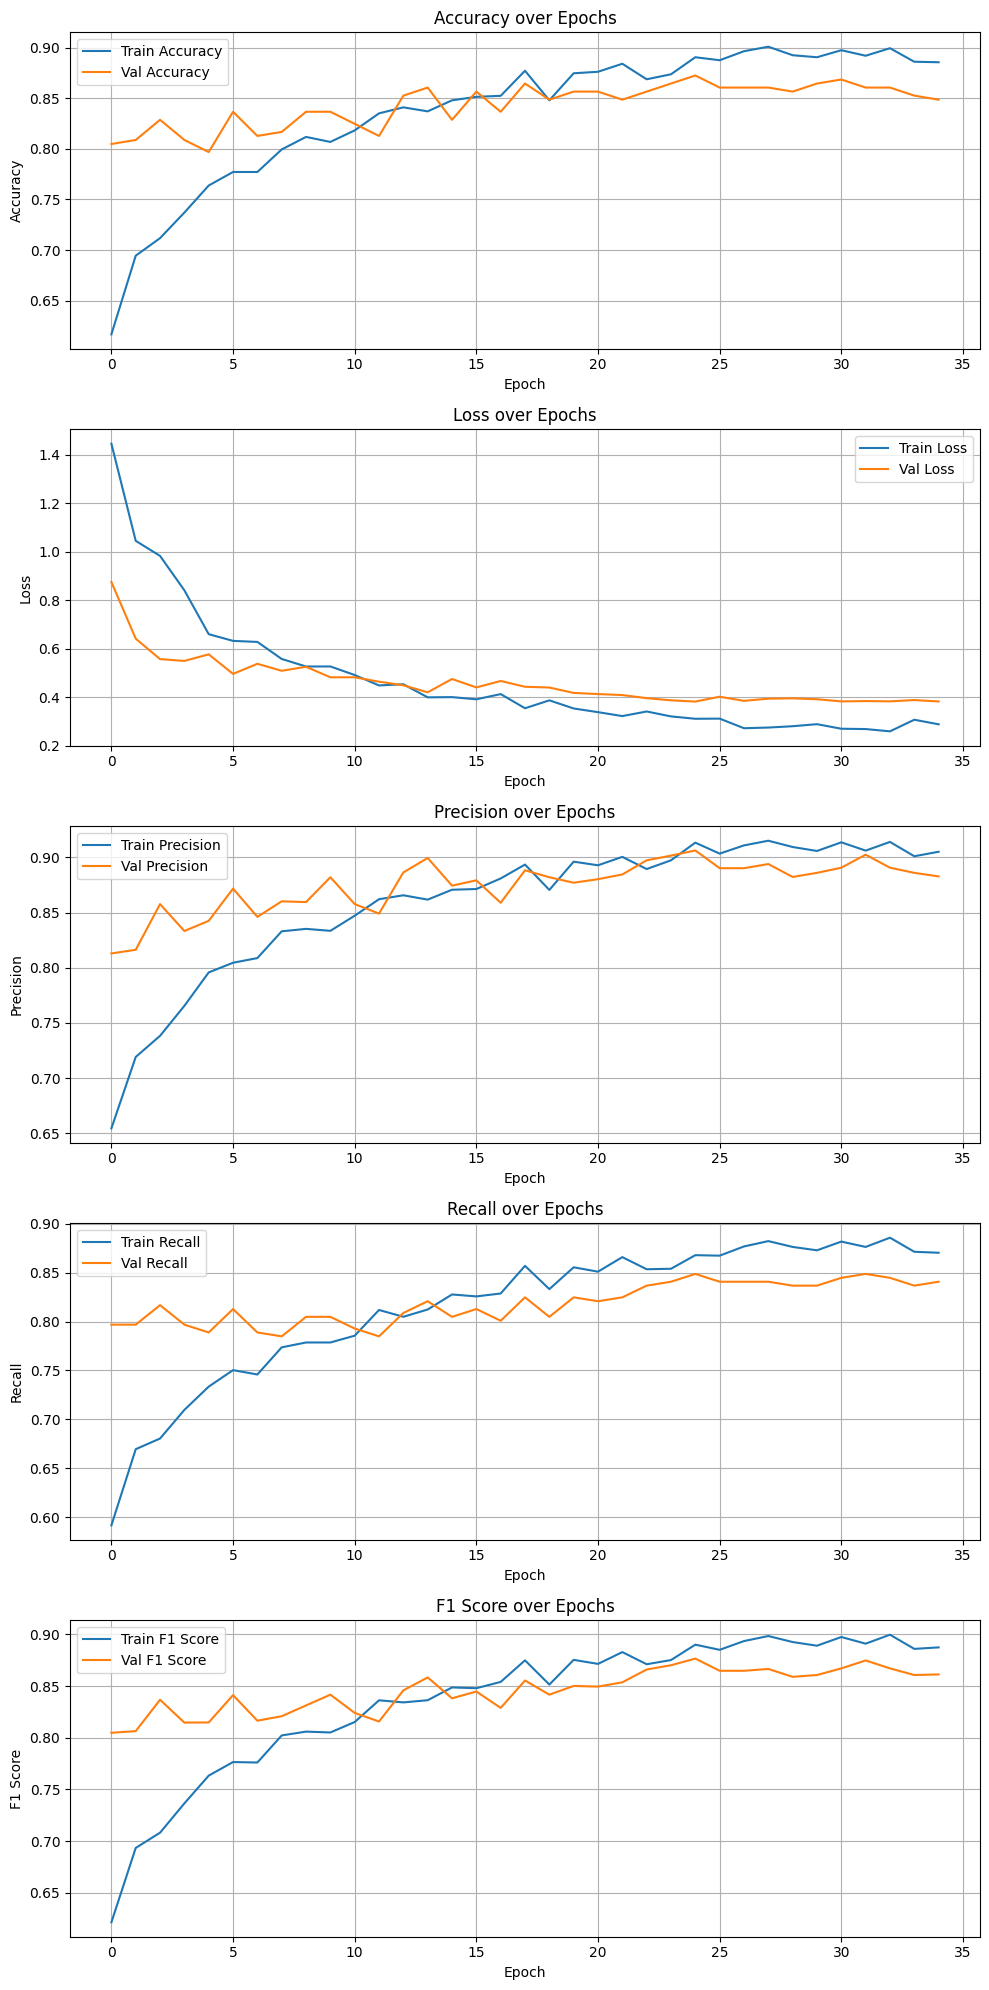

In [56]:
fig, axes = plt.subplots(5, 1, figsize=(10, 20))

# Accuracy
axes[0].plot(history_resnet.history['accuracy'], label='Train Accuracy')
axes[0].plot(history_resnet.history['val_accuracy'], label='Val Accuracy')
axes[0].set_title('Accuracy over Epochs')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss
axes[1].plot(history_resnet.history['loss'], label='Train Loss')
axes[1].plot(history_resnet.history['val_loss'], label='Val Loss')
axes[1].set_title('Loss over Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

# Precision
axes[2].plot(history_resnet.history['precision'], label='Train Precision')
axes[2].plot(history_resnet.history['val_precision'], label='Val Precision')
axes[2].set_title('Precision over Epochs')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Precision')
axes[2].legend()
axes[2].grid(True)

# Recall
axes[3].plot(history_resnet.history['recall'], label='Train Recall')
axes[3].plot(history_resnet.history['val_recall'], label='Val Recall')
axes[3].set_title('Recall over Epochs')
axes[3].set_xlabel('Epoch')
axes[3].set_ylabel('Recall')
axes[3].legend()
axes[3].grid(True)

# F1 Score
axes[4].plot(history_resnet.history['f1_score'], label='Train F1 Score')
axes[4].plot(history_resnet.history['val_f1_score'], label='Val F1 Score')
axes[4].set_title('F1 Score over Epochs')
axes[4].set_xlabel('Epoch')
axes[4].set_ylabel('F1 Score')
axes[4].legend()
axes[4].grid(True)

# Perbaiki tata letak
plt.tight_layout()
plt.show()


- Fungsi `evaluate()` mengembalikan nilai dari fungsi loss dan semua metrik yang sudah didefinisikan saat kompilasi model, dalam urutan yang sama.
- Hasil evaluasi disimpan dalam variabel `loss`, `accuracy`, `precision`, `recall`, dan `f1_score`.
- Kemudian hasilnya dicetak dengan format yang mudah dibaca, menampilkan nilai loss dan metrik performa model pada data test.

In [57]:
loss, accuracy, precision, recall, f1_score = resnet_model.evaluate(test_ds)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test F1 Score: {f1_score}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.8681 - f1_score: 0.8716 - loss: 0.3431 - precision: 0.8847 - recall: 0.8588 
Test Loss: 0.36955204606056213
Test Accuracy: 0.8677042722702026
Test Precision: 0.891566276550293
Test Recall: 0.8638132214546204
Test F1 Score: 0.8774703145027161


- `resnet_model.predict(test_ds)` menghasilkan prediksi probabilitas untuk setiap kelas pada dataset test.
- `np.argmax(y_pred, axis=1)` mengubah prediksi probabilitas menjadi kelas dengan nilai probabilitas tertinggi (kelas prediksi).
- `y_true` menggabungkan semua label asli dari batch-batch dalam `test_ds`.
- `np.argmax(y_true, axis=1)` mengubah label asli one-hot encoding menjadi label kelas asli.
- `confusion_matrix(y_true_classes, y_pred_classes)` menghitung matriks kebingungan (confusion matrix) yang memperlihatkan jumlah prediksi benar dan salah untuk setiap kelas.
- `ConfusionMatrixDisplay` digunakan untuk menampilkan matriks kebingungan dengan label kelas (`class_indices`) sebagai nama pada sumbu X dan Y.
- Plot confusion matrix diberi warna dengan palet biru dan label pada sumbu X diputar 45 derajat untuk keterbacaan yang lebih baik.
- Visualisasi ini membantu untuk melihat performa model secara detail pada tiap kelas, dan mendeteksi kelas mana yang sering salah diprediksi.


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 269ms/step


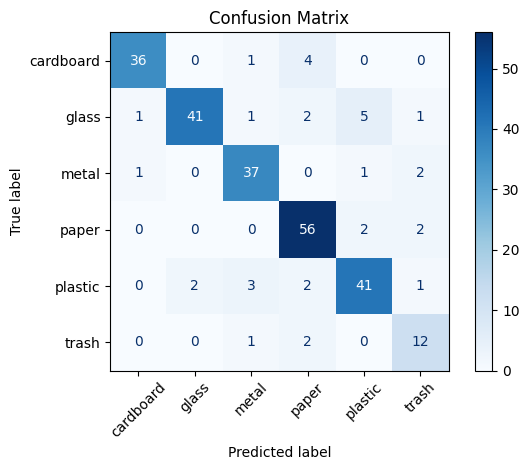

In [58]:
y_pred = resnet_model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true_classes = np.argmax(y_true, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_indices)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()